In [1]:
# magic column V301 id와 묶어서
# productCD  transactionamt 묶어서
# card4
# Transform id_30, id_31¶
# addr2 특정 지역 무적권 사기
# id 30 id31

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
import hashlib
import os
import gc

In [4]:
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()

1107

In [5]:
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect()

0

In [28]:
train['dist1']

0          19.0
1        -999.0
2         287.0
3        -999.0
4        -999.0
          ...  
590535     48.0
590536   -999.0
590537   -999.0
590538      3.0
590539   -999.0
Name: dist1, Length: 590540, dtype: float16

In [6]:
test.columns = test.columns.str.replace('-', '_')

In [10]:
selected_features = ['TransactionDT',
 'TransactionAmt','card1','card2','card3','card5',
 'addr1','addr2',
 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','V307',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain', 
 'dist1','id_30','id_31', 'id_32', 'id_33', 'id_34',
 'DeviceType','DeviceInfo',
  'V314', 'V310', 'V127', 'V78', 'V62'
 ,'id_19','id_20'
 ]

len(selected_features)

64

In [11]:
train = train[selected_features + ['isFraud']]
test = test[selected_features ]

In [12]:
# train = train.fillna(-999)
# test = test.fillna(-999)

In [13]:
# 점수비교 
# https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again

train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp.index = list(temp[col])
        temp = temp[new_col_name].to_dict()
        
        train[new_col_name] = train[col].map(temp)
        test[new_col_name]  = test[col].map(temp)
        
########################### Anomaly Search in geo information

# Let's look on bank addres and client addres matching
# card3/card5 bank country and name?
# Addr2 -> Clients geo position (country)
# Most common entries -> normal transactions
# Less common etries -> some anonaly
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp = pd.concat([train[[col]], test[[col]]])
    temp[col] = np.where(temp[col].str.contains('nan'), np.nan, temp[col])
    temp = temp.dropna()
    fq_encode = temp[col].value_counts().to_dict()   
    train[col] = train[col].map(fq_encode)
    test[col]  = test[col].map(fq_encode)

train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match']  = test['address_match']/test['bank_type']

user

In [14]:
# id_19와 id_20을 결합하여 user 변수 생성
train['user'] = train['id_19'].astype(str) + '_' + train['id_20'].astype(str)
test['user'] = test['id_19'].astype(str) + '_' + test['id_20'].astype(str)

# 기존 i_cols에 user 추가
i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'user']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col, 'TransactionAmt']]])
        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
            columns={agg_type: new_col_name})
        
        temp.index = list(temp[col])
        temp = temp[new_col_name].to_dict()
        
        train[new_col_name] = train[col].map(temp)
        test[new_col_name] = test[col].map(temp)

Date

In [15]:
import datetime

# timeblock으로 시간을 만드는 코드 

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train['timeblock'] = train['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)
test['timeblock'] = test['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)

tb = train['timeblock']
train.drop('timeblock', axis=1, inplace=True)
train.insert(0, 'timeblock', tb)

tb = test['timeblock']
test.drop('timeblock', axis=1, inplace=True)
test.insert(0, 'timeblock', tb)

# "가입일로부터의 시간"(D8)을 통해 "가입일"을 만드는 코드. 
def account_start_date(val):
    if np.isnan(val):
        return np.NaN
    else:
        days = int(str(val).split('.')[0])
        return pd.Timedelta(str(days) + ' days')

for i in ['D1', 'D2', 'D4', 'D8', 'D10', 'D15']:
    train['account_start_day'] = train[i].apply(account_start_date)
    test['account_start_day'] = test[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train['account_make_date'] = (train['timeblock'] - train['account_start_day']).dt.date
    test['account_make_date'] = (test['timeblock'] - test['account_start_day']).dt.date

    train['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train['account_make_date']).dt.year) + (100 * pd.to_datetime(train['account_make_date']).dt.month) + (1 * pd.to_datetime(train['account_make_date']).dt.day)
    test['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test['account_make_date']).dt.year) + (100 * pd.to_datetime(test['account_make_date']).dt.month) + (1 * pd.to_datetime(test['account_make_date']).dt.day)

del train['account_make_date']; del test['account_make_date']
del train['account_start_day']; del test['account_start_day']
train['date'] = pd.to_datetime(train['timeblock']).dt.date
test['date'] = pd.to_datetime(test['timeblock']).dt.date

train['year'] = train['timeblock'].dt.year
train['month'] = train['timeblock'].dt.month
train['day'] = train['timeblock'].dt.day
train['dayofweek'] = train['timeblock'].dt.dayofweek
train['hour'] = train['timeblock'].dt.hour
# train['minute'] = train['timeblock'].dt.minute
# train['second'] = train['timeblock'].dt.second

test['year'] = test['timeblock'].dt.year
test['month'] = test['timeblock'].dt.month
test['day'] = test['timeblock'].dt.day
test['dayofweek'] = test['timeblock'].dt.dayofweek
test['hour'] = test['timeblock'].dt.hour
# test['minute'] = test['timeblock'].dt.minute
# test['second'] = test['timeblock'].dt.second


Card_device 조합에서 V307 적용

In [16]:

def card_info_hash(x):
    s = (str(int(x['card1']))+
         str(int(x['card2']))+
         str(int(x['card3']))+
         str(x['card4'])+
         str(int(x['card5']))+
         str(x['card6']))
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

def device_hash(x):
    s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1   )
train['device_hash'] = train.apply(lambda x: device_hash(x), axis=1   )

test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1   )
test['device_hash'] = test.apply(lambda x: device_hash(x), axis=1   )

In [29]:
train['card_hash']

0          8296
1          8152
2          8694
3          7408
4         12607
          ...  
590535     2928
590536    11801
590537    12880
590538     6157
590539     4272
Name: card_hash, Length: 590540, dtype: int32

In [17]:
train['V307_diff'] = train['V307'].diff().shift(-1)
train['difference'] = train['V307_diff'] - train['TransactionAmt']

test['v307_diff'] = test['V307'].diff().shift(-1)
test['difference'] = test['v307_diff'] - test['TransactionAmt']

prev / next click


In [18]:
# train['uid2_prev_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(1)
# test['uid2_prev_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(1)
total = pd.concat([train,test],axis=0,sort=False)

train['uid2_next_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(-1)
test['uid2_next_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(-1)
del train['uid']; del train['uid2']; del train['bank_type']
del test['uid']; del test['uid2']; del test['bank_type']
train = train.merge(total.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])
test = test.merge(total.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])
train = train.merge(total.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])
test = test.merge(total.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])

In [19]:

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and not np.issubdtype(col_type, np.datetime64):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 적용
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 470.82 MB
Memory usage after optimization is: 208.94 MB
Decreased by 55.6%
Memory usage of dataframe is 400.10 MB
Memory usage after optimization is: 179.76 MB
Decreased by 55.1%


In [20]:
test = test.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo','id_19','id_20'], axis=1)
train = train.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo','id_19','id_20'], axis=1)

Extract target variable¶


In [21]:
from sklearn.preprocessing import LabelEncoder

# 범주형 열을 숫자형으로 변환
def encode_categorical_columns(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders

# train 데이터 인코딩
train, _ = encode_categorical_columns(train)

# test 데이터 인코딩
test_encoded, _ = encode_categorical_columns(test)

In [22]:
train_columns = train.shape[1]
test_columns = test_encoded.shape[1]

print("Number of columns in train:", train_columns)
print("Number of columns in test_encoded:", test_columns)

Number of columns in train: 101
Number of columns in test_encoded: 100


In [23]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Convert DateTime columns to numerical format
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # Convert to seconds since epoch
    return df

# Assuming X is your feature DataFrame
X = convert_datetime_columns(X)

# train, valid split
X_tr, X_v, y_tr, y_v = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y)

# 데이터 셋 생성
train_data = lgb.Dataset(X_tr, label=y_tr)
valid_data = lgb.Dataset(X_v, label=y_v)

params = {
    'objective': 'binary',
    'metric': 'auc'
}

# 모델 학습
callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
clf = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)

[LightGBM] [Info] Number of positive: 15497, number of negative: 427408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17975
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317093
[LightGBM] [Info] Start training from score -3.317093
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.954261	valid_1's auc: 0.938832
[200]	training's auc: 0.972847	valid_1's auc: 0.951871
[300]	training's auc: 0.982667	valid_1's auc: 0.959444
[400]	training's auc: 0.988539	valid_1's auc: 0.963443
[500]	training's auc: 0.992071	valid_1's auc: 0.965297
[600]	training's auc: 0.994594	valid_1's auc: 0.967571
[700]	training's auc: 0.996338	valid_1's auc: 0.969064
[800]	training's auc: 0.99759	valid_1's auc: 0.969973
[

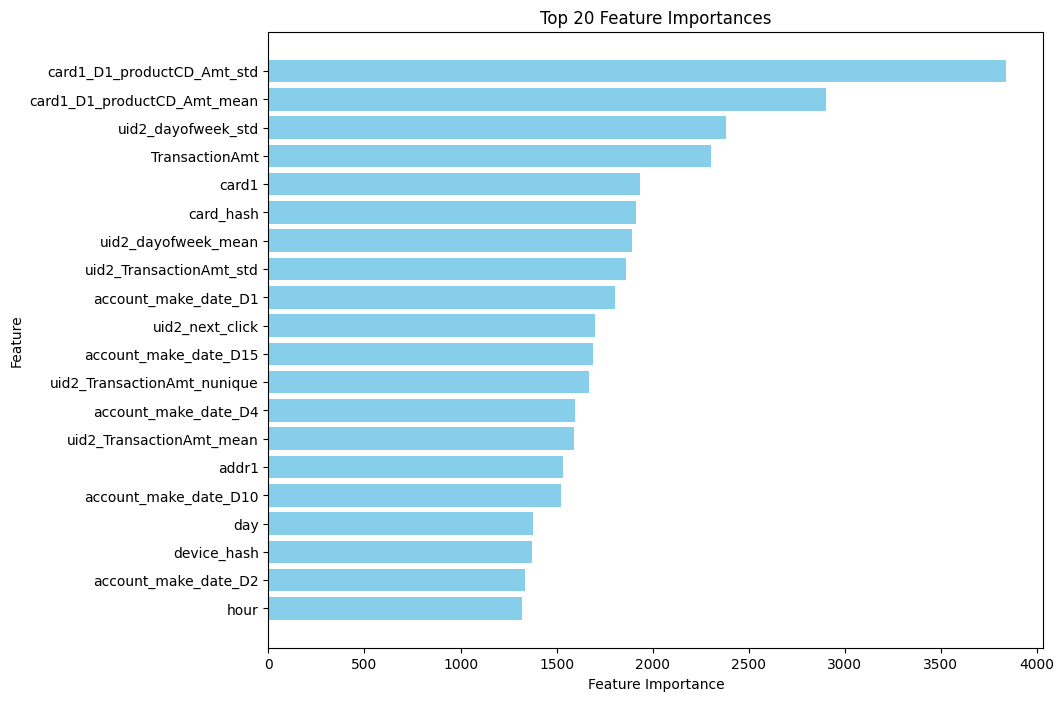

In [25]:
import matplotlib.pyplot as plt
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 중요도 순으로 정렬하고 상위 20개 피처 선택
top_20_features = importance_df.sort_values(by='importance', ascending=False).head(20)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()

In [26]:
# DateTime64 타입의 열을 숫자 형식으로 변환하는 함수
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # 초 단위로 변환
    return df

# test_encoded 데이터프레임의 DateTime64 타입 열 변환
test_encoded = convert_datetime_columns(test_encoded)

# 예측 수행
preds = clf.predict(test_encoded)

# 결과 저장
result = pd.read_csv("sample_submission.csv")
result['isFraud'] = preds
result.to_csv('result.csv', index=False)

In [27]:
def print_columns(df):
    print("Columns in the DataFrame:")
    print(", ".join(df.columns))

print_columns(test_encoded)

print_columns(train)

Columns in the DataFrame:
timeblock, TransactionDT, TransactionAmt, card1, card2, card3, card5, addr1, addr2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, ProductCD, card4, card6, P_emaildomain, R_emaildomain, dist1, id_34, V314, V310, V127, V78, V62, id_12, id_15, id_16, id_28, id_29, id_27, card1_TransactionAmt_mean, card1_TransactionAmt_std, card1_TransactionAmt_nunique, card2_TransactionAmt_mean, card2_TransactionAmt_std, card2_TransactionAmt_nunique, card3_TransactionAmt_mean, card3_TransactionAmt_std, card3_TransactionAmt_nunique, card5_TransactionAmt_mean, card5_TransactionAmt_std, card5_TransactionAmt_nunique, uid_TransactionAmt_mean, uid_TransactionAmt_std, uid_TransactionAmt_nunique, uid2_TransactionAmt_mean, uid2_TransactionAmt_std, uid2_TransactionAmt_nunique, address_match, user, user_TransactionAmt_mean, user_TransactionAmt_std, user_TransactionAmt_nunique, account_make_date_D1, account_make

In [1]:
columns = [
    "timeblock", "TransactionDT", "TransactionAmt", "card1", "card2", "card3", "card5", "addr1", "addr2", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12", "D13", "D14", "D15", "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", "dist1", "id_34", "V314", "V310", "V127", "V78", "V62", "id_12", "id_15", "id_16", "id_28", "id_29", "id_27", "isFraud", "card1_TransactionAmt_mean", "card1_TransactionAmt_std", "card1_TransactionAmt_nunique", "card2_TransactionAmt_mean", "card2_TransactionAmt_std", "card2_TransactionAmt_nunique", "card3_TransactionAmt_mean", "card3_TransactionAmt_std", "card3_TransactionAmt_nunique", "card5_TransactionAmt_mean", "card5_TransactionAmt_std", "card5_TransactionAmt_nunique", "uid_TransactionAmt_mean", "uid_TransactionAmt_std", "uid_TransactionAmt_nunique", "uid2_TransactionAmt_mean", "uid2_TransactionAmt_std", "uid2_TransactionAmt_nunique", "address_match", "user", "user_TransactionAmt_mean", "user_TransactionAmt_std", "user_TransactionAmt_nunique", "account_make_date_D1", "account_make_date_D2", "account_make_date_D4", "account_make_date_D8", "account_make_date_D10", "account_make_date_D15", "date", "year", "month", "day", "dayofweek", "hour", "card_hash", "device_hash", "V307_diff", "difference", "uid2_next_click", "card1_D1_productCD_Amt_std", "card1_D1_productCD_Amt_mean", "uid2_dayofweek_std", "uid2_dayofweek_mean"
]

transaction_amt_columns = [col for col in columns if "TransactionAmt" in col]

print(transaction_amt_columns)

['TransactionAmt', 'card1_TransactionAmt_mean', 'card1_TransactionAmt_std', 'card1_TransactionAmt_nunique', 'card2_TransactionAmt_mean', 'card2_TransactionAmt_std', 'card2_TransactionAmt_nunique', 'card3_TransactionAmt_mean', 'card3_TransactionAmt_std', 'card3_TransactionAmt_nunique', 'card5_TransactionAmt_mean', 'card5_TransactionAmt_std', 'card5_TransactionAmt_nunique', 'uid_TransactionAmt_mean', 'uid_TransactionAmt_std', 'uid_TransactionAmt_nunique', 'uid2_TransactionAmt_mean', 'uid2_TransactionAmt_std', 'uid2_TransactionAmt_nunique', 'user_TransactionAmt_mean', 'user_TransactionAmt_std', 'user_TransactionAmt_nunique']
